In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from src.settings import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
import gzip
from src.tools.configs import DatasetGenerationConfig
from src.tools.feature_extraction import SpatialDataset
import pickle as pkl
from src.tools.feature_extraction import apply_feature_selection, apply_features_mapping, apply_features_assume
import seaborn as sns
from src.tools.vis_utils import visualize_kepler, save_config


tqdm.pandas()

In [3]:
# dataset_filename="dataset_2022-01-04_20-41-53_poland.pkl.gz"
dataset_filename="dataset_2022-01-04_20-50-24_all.pkl.gz"


ds_path = FEATURES_DIR / dataset_filename
with gzip.open(ds_path, "rb") as f:
    ds: SpatialDataset = pkl.load(f)

ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'edges_feature_selected': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [4]:
ds_config = ds.config
cities = ds.cities
edges = ds.edges
edges_feature_selected = ds.edges_feature_selected
hexagons = ds.hexagons
hex_agg = ds.hex_agg
hex_agg_normalized = ds.hex_agg_normalized
random_seed = 42

In [5]:
# edges_selected = apply_feature_selection(edges, ds_config.featureset_selection)
# edges_selected = apply_features_mapping(edges_selected, [{
#     "feature": "highway",
#     "mapping": {
#         "motorway_link": "motorway",
#         "primary_link": "primary",
#         "secondary_link": "secondary",
#         "tertiary_link": "tertiary",
#         "trunk_link": "trunk"
#     }
# }])
# edges = apply_features_mapping(edges, [{
#     "feature": "surface",
#     "mapping": {
#         "asphalt": "paved",
#         "paving_stones": "paved",
#         "concrete": "paved",
#         "concrete_prefabricated": "paved",
#         "compacted": "unpaved",
#         "ground": "unpaved"
#     }
# }])
# # edges_selected = apply_features_mapping(edges_selected, [{
# #     "feature": "highway",
# #     "mapping": {
# #         'secondary': 'not_residential', 
# #         'tertiary': 'not_residential', 
# #         'living_street': 'not_residential', 
# #         'primary': 'not_residential', 
# #         'unclassified': 'not_residential', 
# #         'motorway': 'not_residential', 
# #         'trunk': 'not_residential'
# #     }
# # }])
# edges = apply_features_assume(edges, {
#       "surface": "paved",
# })
# edges_selected

In [6]:
feature_items = [(a, [f"{a}_{c}" for c in b]) for a, b in ds_config.featureset_selection["features"].items()]
edges_long = gpd.GeoDataFrame()
pbar = tqdm(feature_items)
for feature_name, features_superset in pbar:
    pbar.set_description(feature_name)
    features = list(set(edges_feature_selected.columns) & set(features_superset))
    try: 
        edges_long[feature_name] = edges_feature_selected[features].idxmax(axis=1).astype("category")
        edges_long[feature_name][edges_feature_selected[features].sum(axis=1) == 0] = None
    except Exception as e:
        print(e)
edges_long["geometry"] = edges["geometry"]
edges_long

surface: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


oneway    lanes  \
continent country    city       h3_id                                    
Asia      Kazakhstan Nur-Sultan 89215382263ffff   oneway_True  lanes_2   
                                89215382263ffff   oneway_True      NaN   
                                8921538227bffff   oneway_True      NaN   
                                89215382273ffff   oneway_True      NaN   
                                89215382263ffff   oneway_True  lanes_2   
...                                                       ...      ...   
Oceania   Australia  Sydney     89be0845cc7ffff  oneway_False      NaN   
                                89be0845c8bffff  oneway_False      NaN   
                                89be0845c83ffff  oneway_False      NaN   
                                89be0844223ffff   oneway_True      NaN   
                                89be0844233ffff   oneway_True      NaN   

                                                              highway  \
continent country    city       h3_id                                   
Asia      Kazakhstan Nur-Sultan 89215382263ffff     highway_secondary   
                                89215382263ffff   highway_residential   
                                8921538227bffff   highway_residential   
                                89215382273ffff   highway_residential   
                                89215382263ffff     highway_secondary   
...                                                               ...   
Oceania   Australia  Sydney     89be0845cc7ffff  highway_unclassified   
                                89be0845c8bffff  highway_unclassified   
                                89be0845c83ffff   highway_residential   
                                89be0844223ffff   highway_residential   
                                89be0844233ffff   highway_residential   

                                                    maxspeed bridge access  \
continent country    city       h3_id                                        
Asia      Kazakhstan Nur-Sultan 89215382263ffff  maxspeed_60    NaN    NaN   
                                89215382263ffff          NaN    NaN    NaN   
                                8921538227bffff          NaN    NaN    NaN   
                                89215382273ffff          NaN    NaN    NaN   
                                89215382263ffff  maxspeed_60    NaN    NaN   
...                                                      ...    ...    ...   
Oceania   Australia  Sydney     89be0845cc7ffff          NaN    NaN    NaN   
                                89be0845c8bffff          NaN    NaN    NaN   
                                89be0845c83ffff          NaN    NaN    NaN   
                                89be0844223ffff          NaN    NaN    NaN   
                                89be0844233ffff          NaN    NaN    NaN   

                                                junction width tunnel  \
continent country    city       h3_id                                   
Asia      Kazakhstan Nur-Sultan 89215382263ffff      NaN   NaN    NaN   
                                89215382263ffff      NaN   NaN    NaN   
                                8921538227bffff      NaN   NaN    NaN   
                                89215382273ffff      NaN   NaN    NaN   
                                89215382263ffff      NaN   NaN    NaN   
...                                                  ...   ...    ...   
Oceania   Australia  Sydney     89be0845cc7ffff      NaN   NaN    NaN   
                                89be0845c8bffff      NaN   NaN    NaN   
                                89be0845c83ffff      NaN   NaN    NaN   
                                89be0844223ffff      NaN   NaN    NaN   
                                89be0844233ffff      NaN   NaN    NaN   

                                                         surface  \
continent country    city       h3_id                              
Asia      Kazakhstan Nur-Sultan 892153822

In [7]:
# config_name = "edges_raw"

# edges_keplergl = edges_long.astype(str).reset_index().drop(columns=["h3_id"])
# hexagons_keplergl = hexagons.reset_index().drop(columns=["coordinates", "parent", "children"])
# hexagons_keplergl["h3_id"] = hexagons_keplergl["h3_id"].map(lambda x: f"hex_{x}")
# m = visualize_kepler(data={
#         "edges": edges_keplergl,
#         "hexagons": hexagons_keplergl
#     }, 
#     config_name=config_name)
# m

In [8]:
# save_config(m, config_name=config_name)

In [9]:
plt.style.use('seaborn-paper')

# Geo counts


In [10]:
df_index = edges.index.droplevel(3).unique().to_frame().reset_index(drop=True)

In [11]:
len(df_index)

97

<AxesSubplot:ylabel='Continent'>

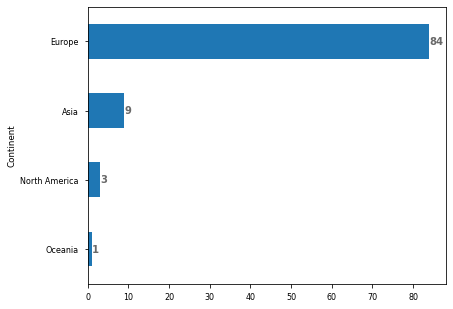

In [12]:
df_continents = df_index.groupby("continent")["country"].count().sort_values()
ax = df_continents.plot(kind="barh", xlabel="Continent", ylabel="Count")
for i, v in enumerate(df_continents):
    ax.text(v, i, str(v), color='dimgray', va='center', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cities_in_continents_count.png")
ax

<AxesSubplot:ylabel='Country'>

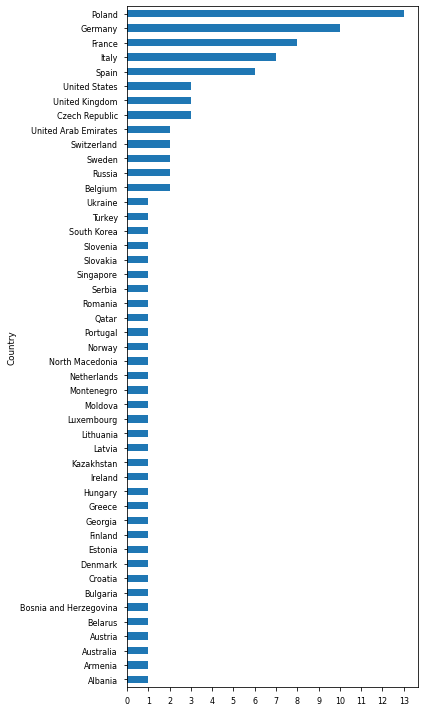

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
df_countries = df_index.groupby("country")["city"].count().reset_index().sort_values(["city", "country"])
ax = df_countries.plot(kind="barh", x="country", y="city", xlabel="Country", ax=ax, legend=False)
# for i, v in enumerate(df_countries):
#     ax.text(v, i, " " + str(v), color='dimgray', va='center')
plt.xticks(ticks=np.arange(df_countries["city"].max() + 1))
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cities_in_countries_count.png")
ax

# Edges

In [14]:
len(edges_long)

3397346

<AxesSubplot:xlabel='continent'>

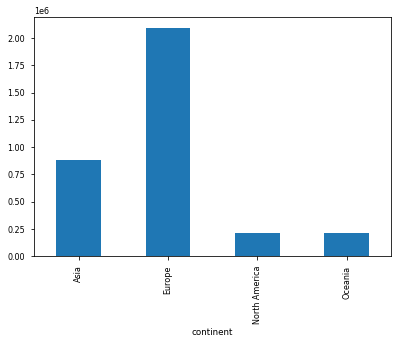

In [15]:
edges["u"].groupby(level=0).count().plot(kind="bar")

<AxesSubplot:xlabel='country'>

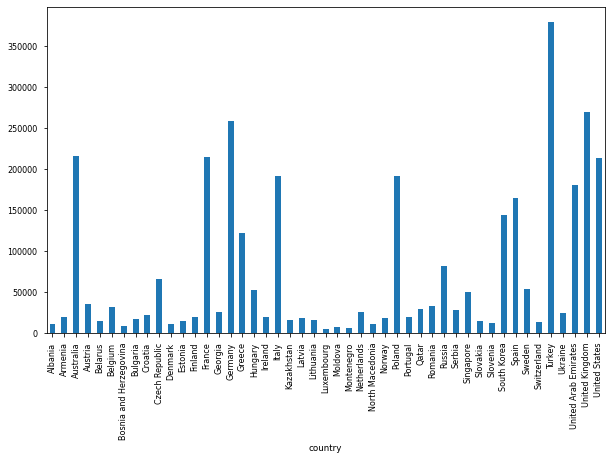

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
edges["u"].groupby(level=1).count().plot(kind="bar", ax=ax)

<AxesSubplot:xlabel='city'>

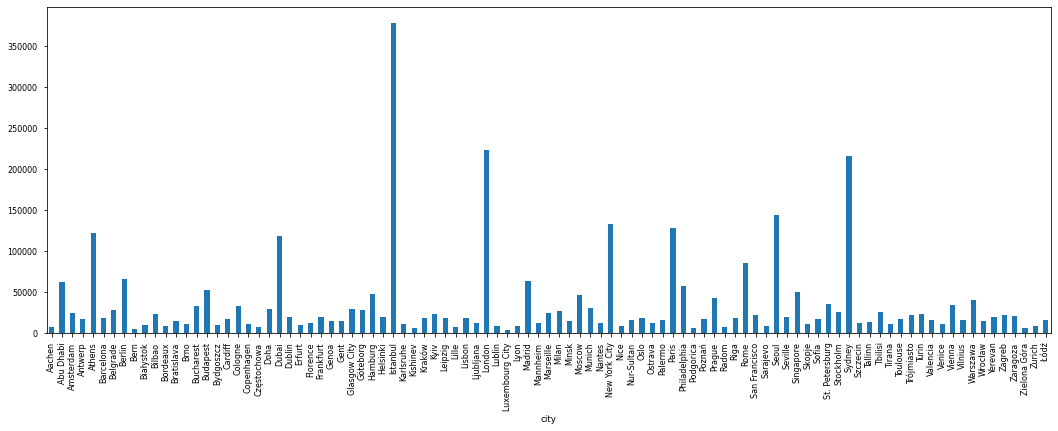

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
# edges.xs("Poland", level=1, drop_level=False)["u"].groupby(level=2).count().plot(kind="bar", ax=ax)
edges["u"].groupby(level=2).count().plot(kind="bar", ax=ax)

# Hexagons


In [18]:
len(hexagons)

559784

<AxesSubplot:xlabel='continent'>

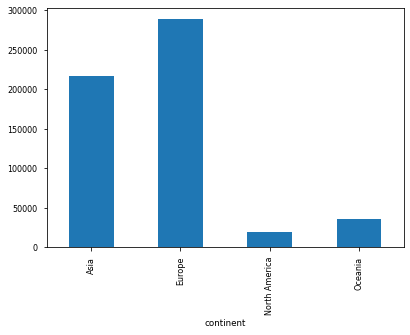

In [19]:
hexagons["parent"].groupby(level=0).count().plot(kind="bar")

<AxesSubplot:xlabel='country'>

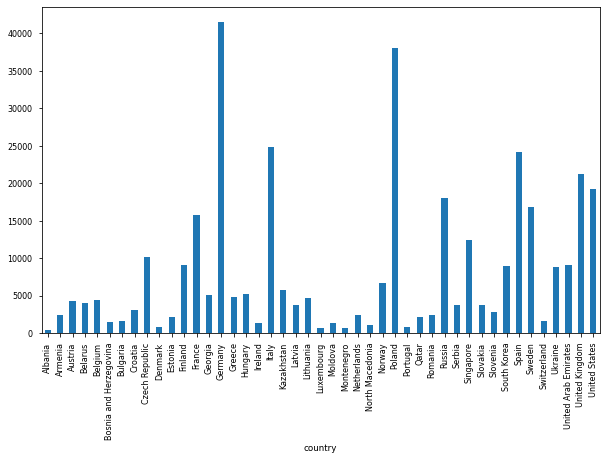

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hexagons["parent"].drop(index=["Dubai", "Istanbul", "Sydney"], level=2).groupby(level=1).count().plot(kind="bar", ax=ax)

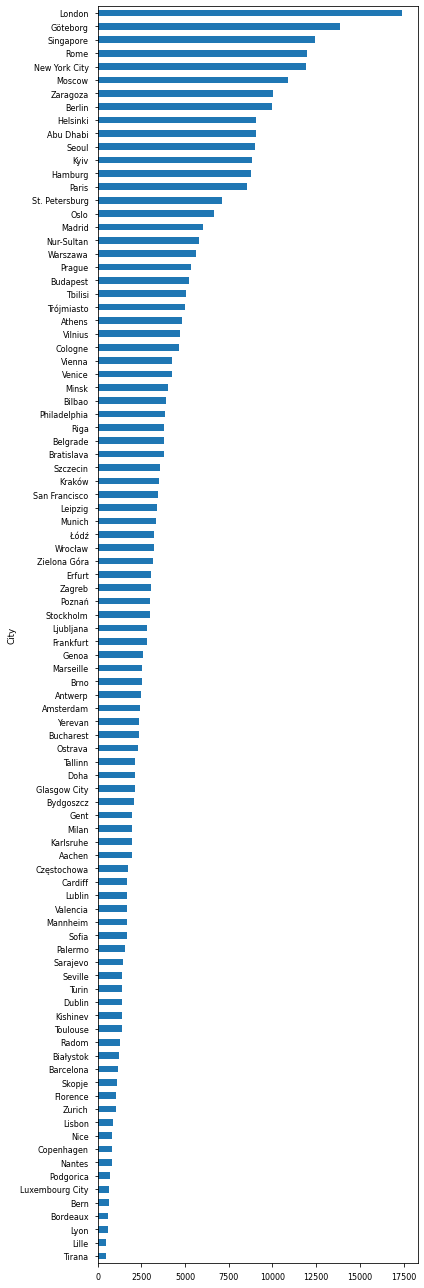

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 18))
# hexagons.xs("Poland", level=1, drop_level=False)["parent"].groupby(level=2).count().plot(kind="bar", ax=ax)
hexagons_in_cities_count = hexagons["parent"].groupby(level=2).count()\
.drop(index=["Dubai", "Istanbul", "Sydney"])\
.sort_values()
hexagons_in_cities_count.plot(kind="barh", ax=ax, xlabel="City")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "hexagons_in_cities_count.png")

# Hex_agg


In [22]:
len(hex_agg)

271393

<AxesSubplot:xlabel='continent'>

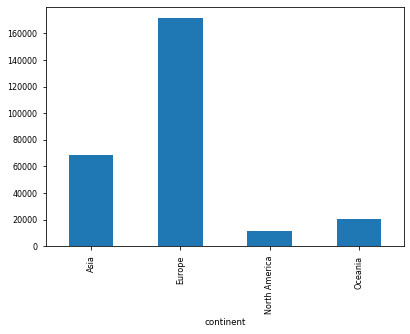

In [23]:
hex_agg["oneway_True"].groupby(level=0).count().plot(kind="bar")

<AxesSubplot:xlabel='country'>

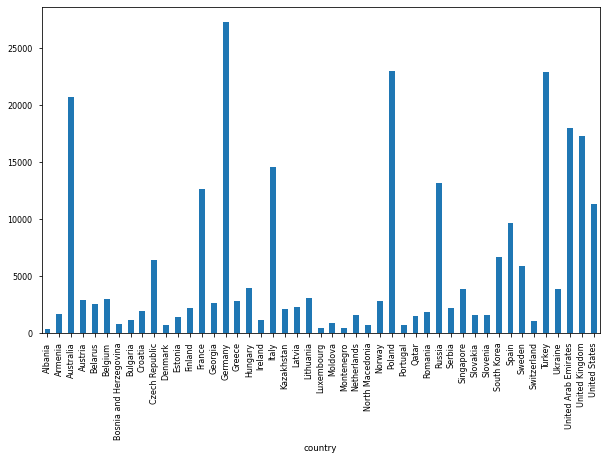

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
hex_agg["oneway_True"].groupby(level=1).count().plot(kind="bar", ax=ax)

<AxesSubplot:xlabel='city'>

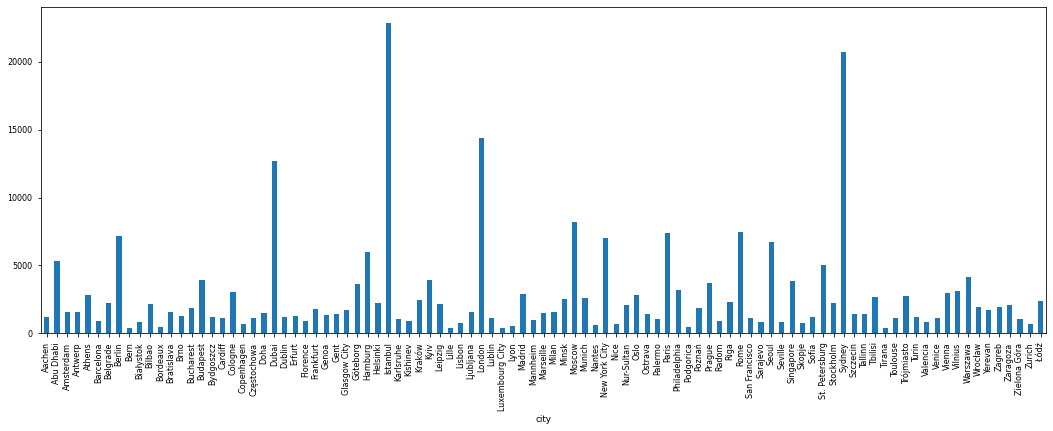

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
# hex_agg.xs("Poland", level=1, drop_level=False)["oneway_True"].groupby(level=2).count().plot(kind="bar", ax=ax)
hex_agg["oneway_True"].groupby(level=2).count().plot(kind="bar", ax=ax)

# Features

In [26]:
import plotly.io as pio
print(pio.templates)
pio.templates.default = "none"

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [27]:
n = len(edges_long)
edges_feature_count = pd.DataFrame(edges_long.drop(columns="geometry").notnull().sum().sort_values(ascending=False), columns=["count"])
edges_feature_share = round(100 * edges_feature_count / n, 2).rename(columns={"count": "Share"})
fig = px.bar(
    edges_feature_share.reset_index(),
    x="index",
    y="Share", 
    width=800,
    height=400, 
    title=f"Feature occurrence in {n} road segments",
    text="Share",
    color="Share",
    # color_continuous_scale="Turbo",
)
fig.update_layout(
    xaxis = dict(
        title = "Feature"
    ),
    yaxis = dict(
        title = "Share",
        range = [-1, 110]
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    showlegend = False   
)
fig.update_traces( textposition='outside')
fig.show()
fig.write_image(FIGURES_DIR / "feature_shares.jpg")

In [28]:
for feature_name, features in feature_items:
    feature_counts = pd.DataFrame(edges_long[feature_name].value_counts().reindex(features, fill_value=0))
    feature_shares = round(100 * feature_counts / feature_counts.sum(), 2).rename(columns={feature_name: "Share"})
    feature_shares = feature_shares.set_index(feature_shares.index.map(lambda x: x.split("_", 1)[1]))
    fig = px.bar(
        feature_shares.reset_index(), 
        x="index",
        y="Share", 
        text="Share",
        color="Share",
        width=800,
        height=400, 
        title=(f"{feature_name.capitalize()} (n = {feature_counts[feature_name].sum()})"), 
        log_y=True,
    )
    fig.update_layout(
        xaxis = dict(
            # tickmode = 'linear',
            type="category",
            title = feature_name
        ),
        yaxis = dict(
            title = "Share",
            range = [-2, 2.3]
        ),
        margin=dict(l=50, r=50, t=50, b=100),
        showlegend=False
    )
    fig.update_traces( textposition='outside')
    fig.write_image(FIGURES_DIR / f"feature_{feature_name}_shares.jpg")
    fig.show()

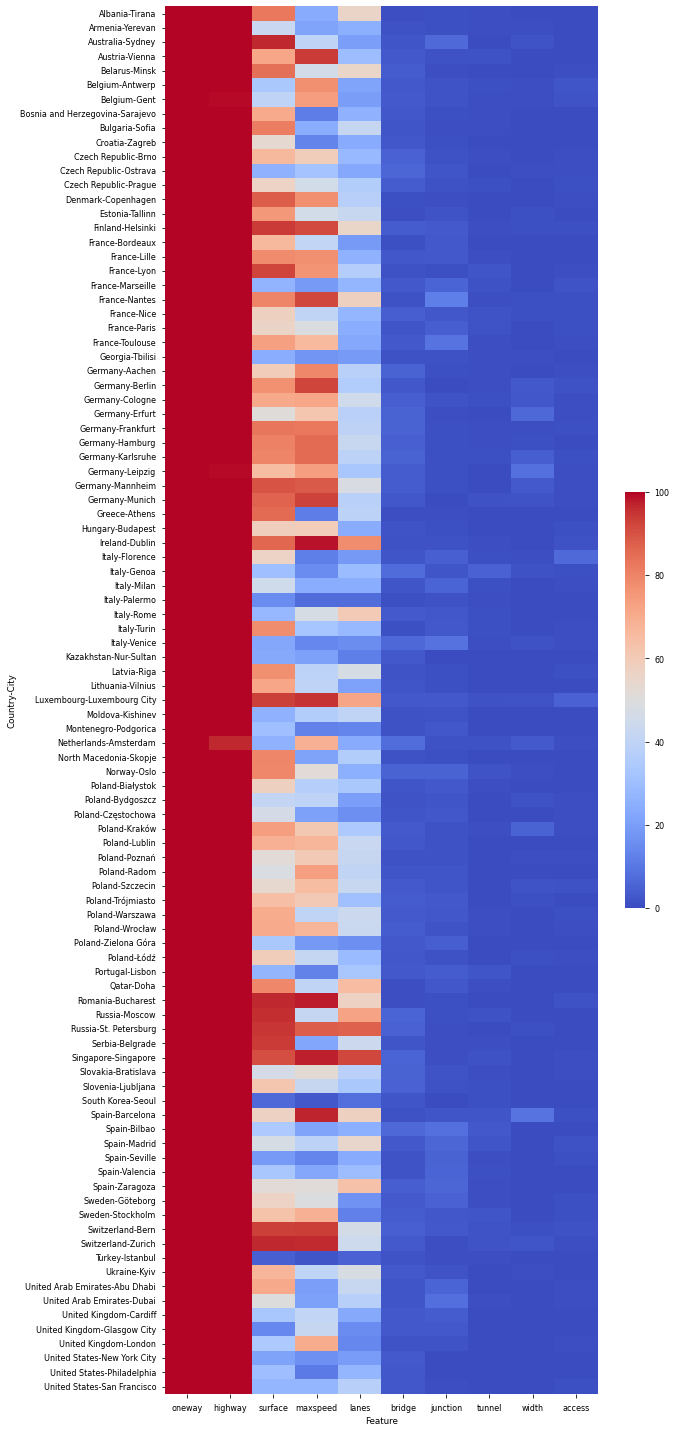

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
sorted_columns_by_notnull_count = list(edges_long.drop(columns=["geometry"]).notnull().sum().sort_values(ascending=False).index)
city_feature_occurance = edges_long.groupby(level=[0, 1, 2]).count().div(edges_long.reset_index(level=3)["h3_id"].groupby(level=[0, 1, 2]).count(), axis=0) * 100
city_feature_occurance = city_feature_occurance.droplevel(level=0).sort_index().drop(columns="geometry").reindex(columns=sorted_columns_by_notnull_count)
sns.heatmap(data=city_feature_occurance, ax=ax, cmap="coolwarm", cbar_kws={"shrink": 0.3})
plt.ylabel("Country-City")
plt.xlabel("Feature")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "city_feature_occurance.svg")

In [30]:
# feature_keys = list(map(lambda x: x[0], feature_items))
# edges_long_decategorized = edges_long.copy()
# for f in tqdm(feature_keys):
#     edges_long_decategorized[f] = edges_long_decategorized[f].map(lambda x: x.split("_", 2)[1])
#     if f in ["lanes", "maxspeed", "width"]:
#         edges_long_decategorized[f] = edges_long_decategorized[f].astype(float)
#     else:
#         edges_long_decategorized[f] = edges_long_decategorized[f].astype("category")
# edges_long_decategorized

In [31]:
# sns.pairplot(edges_long_decategorized.reset_index(drop=True).drop(columns="geometry"), vars=feature_keys)